In [1]:
import time 

import numpy as np
import matplotlib.pyplot as plt 

import torch
import torchvision

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


# Seed

In [3]:
seed_number = 44

torch.manual_seed(seed_number)
torch.cuda.manual_seed(seed_number)
torch.cuda.manual_seed_all(seed_number) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed_number)
#random.seed(seed_number)

# MNIST data download

In [4]:
train_dataset = torchvision.datasets.MNIST('./data/', train=True, download=True)
test_dataset  = torchvision.datasets.MNIST('./data/', train=False)

# Load dataset

In [5]:
X      = train_dataset.data
X_test = test_dataset.data

print(X.shape)
print(X_test.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [6]:
y      = train_dataset.targets
y_test = test_dataset.targets

print(y.shape)
print(y_test.shape)

torch.Size([60000])
torch.Size([10000])


# Normalization

In [7]:
X /= 255.
X_test /= 255.

# Model

In [8]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.fully_connected_layer_1 = torch.nn.Linear(784, 256)
        self.fully_connected_layer_2 = torch.nn.Linear(256, 256)
        self.fully_connected_layer_3 = torch.nn.Linear(256, 64)
        self.fully_connected_layer_4 = torch.nn.Linear(64,  10)
        
    def forward(self, xb):
        xb = xb.view(-1, 784)
        
        out = self.fully_connected_layer_1(xb)
        out = torch.nn.ReLU()(out)
        
        out = self.fully_connected_layer_2(out)
        out = torch.nn.ReLU()(out)
        
        out = self.fully_connected_layer_3(out)
        out = torch.nn.ReLU()(out)
        
        out = self.fully_connected_layer_4(out)
        return out

# Cost function

In [9]:
criterion = torch.nn.CrossEntropyLoss()

# Training

In [10]:
train_loss_history, valid_loss_history = [], []

from sklearn.model_selection import KFold
kf = KFold(n_splits=5, random_state=seed_number, shuffle=True)

for cv, (train_index, valid_index) in enumerate(kf.split(X)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]
    
    train_ds = torch.utils.data.TensorDataset(X_train.to(device=device), y_train.to(device=device))
    valid_ds = torch.utils.data.TensorDataset(X_valid.to(device=device), y_valid.to(device=device))
    
    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_ds, batch_size=128, shuffle=False)
    
    # model initialization
    model = Net().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)


    ### training
    is_train = True
    epoch, early_stopping = 0, 0
    train_loss_history_, valid_loss_history_ = [], []

    while is_train:
        start = time.time()
        train_loss, train_count = 0., 0.
        epoch += 1
        early_stopping += 1
    
        for xb, yb in train_loader:
            prediction = model(xb)
            loss = criterion(prediction, yb)
            train_loss += loss.item()*len(yb)
            train_count += len(yb)
        
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    
        with torch.no_grad():
            valid_loss = 0
            valid_accuracy, valid_count = 0., 0.
        
            for xb, yb in valid_loader:
                prediction = model(xb)
                valid_loss += criterion(prediction, yb)*len(yb)
                valid_accuracy += prediction.data.max(1)[1].eq(yb.data).sum()
                valid_count += len(yb)
        
        train_loss /= train_count
        valid_loss /= valid_count    
        valid_accuracy /= valid_count
    
        train_loss_history_.append(train_loss)
        valid_loss_history_.append(valid_loss)
    
        if min(valid_loss_history_) == valid_loss:
            early_stopping = 0
        
            # https://pytorch.org/tutorials/beginner/saving_loading_models.html
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': valid_loss,
            }, f'./CV{cv+1}_model.pt')
        
        if early_stopping == 15:
            is_train = False
            
        print(f"======== CV {cv+1}  Epoch {epoch} =======")
        print(f"Loss => train:{train_loss:.5f}, valid:{valid_loss:.5f}")
        print(f"Accuracy => {valid_accuracy*100:.2f}%, Elapsed time => {time.time()-start:.3f} sec")
        print("=======================================\n")
    
    train_loss_history.append(train_loss_history_)
    valid_loss_history.append(valid_loss_history_)

======== CV 1  Epoch 1 =======
Loss => train:0.45465, valid:0.22116
Accuracy => 93.55%, Elapsed time => 2.574 sec

======== CV 1  Epoch 2 =======
Loss => train:0.17132, valid:0.14614
Accuracy => 95.65%, Elapsed time => 2.596 sec

======== CV 1  Epoch 3 =======
Loss => train:0.11733, valid:0.12228
Accuracy => 96.29%, Elapsed time => 2.705 sec

======== CV 1  Epoch 4 =======
Loss => train:0.08725, valid:0.10139
Accuracy => 96.93%, Elapsed time => 2.782 sec

======== CV 1  Epoch 5 =======
Loss => train:0.06525, valid:0.09307
Accuracy => 97.09%, Elapsed time => 2.729 sec

======== CV 1  Epoch 6 =======
Loss => train:0.05227, valid:0.08574
Accuracy => 97.32%, Elapsed time => 2.752 sec

======== CV 1  Epoch 7 =======
Loss => train:0.04203, valid:0.09768
Accuracy => 97.06%, Elapsed time => 2.750 sec

======== CV 1  Epoch 8 =======
Loss => train:0.03434, valid:0.08376
Accuracy => 97.32%, Elapsed time => 2.800 sec

======== CV 1  Epoch 9 =======
Loss => train:0.02703, valid:0.08460
Accuracy => 

# Learning curve

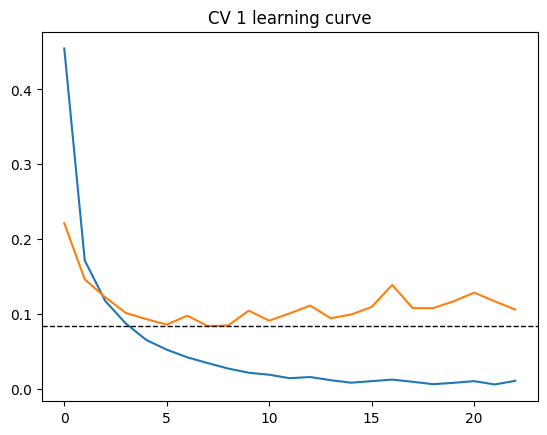

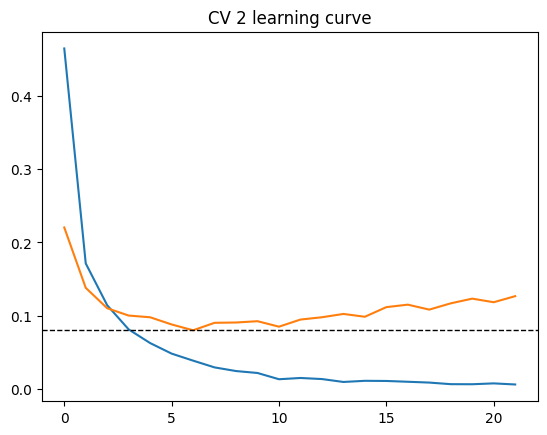

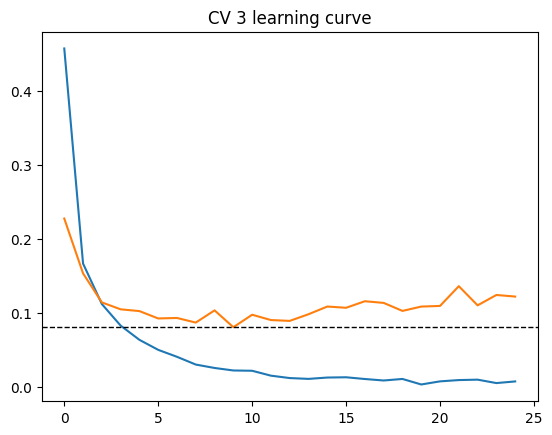

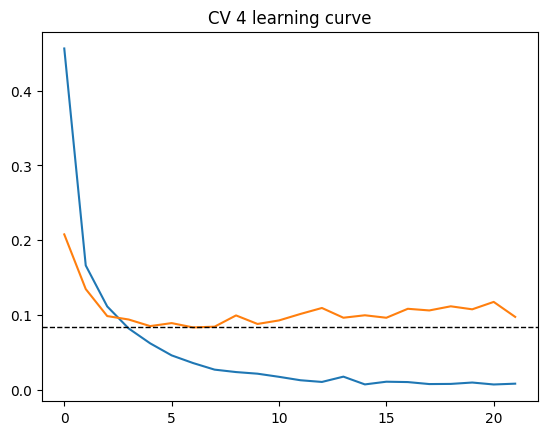

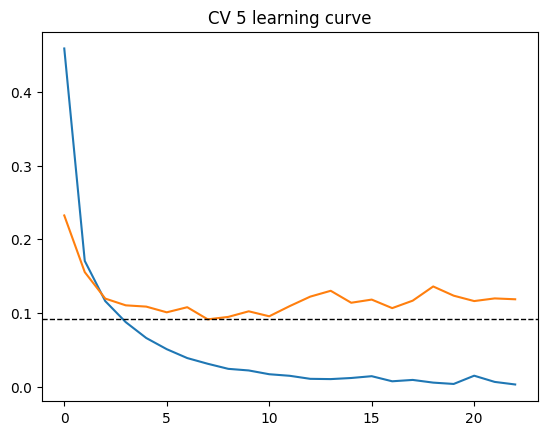

In [11]:
for cv, (train_loss, valid_loss) in enumerate(zip(train_loss_history, valid_loss_history)):
    plt.plot(train_loss)
    plt.plot(valid_loss)
    plt.axhline(y=min(valid_loss), color='black', linestyle='--', linewidth=1)
    plt.title(f'CV {cv+1} learning curve')
    plt.show()

# Evaluation

In [12]:
prediction = torch.zeros([5, len(X_test), 10])

for cv in range(5):
    checkpoint = torch.load(f'./CV{cv+1}_model.pt')
    model.load_state_dict(checkpoint['model_state_dict'])
    prediction[cv,:,:] = model(X_test)

prediction = torch.mean(prediction, dim=0)
loss = criterion(prediction, y_test)
accuracy = prediction.data.max(1)[1].eq(y_test.data).sum() / len(y_test)

print(f"loss: {loss:.5f}")
print(f"accuracy: {accuracy*100:.2f}%")

loss: 0.05762
accuracy: 98.24%


### keep in mind that 'softmax' fucntion was not included in the model architecture

In [13]:
prediction = torch.zeros([5, len(X_test), 10])

for cv in range(5):
    checkpoint = torch.load(f'./CV{cv+1}_model.pt')
    model.load_state_dict(checkpoint['model_state_dict'])
    #prediction[cv,:,:] = model(X_test)
    prediction[cv,:,:] = torch.nn.Softmax(dim=1)(model(X_test))

prediction = torch.mean(prediction, dim=0)
accuracy = prediction.data.max(1)[1].eq(y_test.data).sum() / len(y_test)
print(f"accuracy: {accuracy*100:.2f}%")

accuracy: 98.29%


In [14]:
prediction = torch.zeros([5, 1, 10])

for cv in range(5):
    checkpoint = torch.load(f'./CV{cv+1}_model.pt')
    model.load_state_dict(checkpoint['model_state_dict'])
    #prediction[cv,0,:] = model(X_test[1000])
    prediction[cv,0,:] = torch.nn.Softmax(dim=1)(model(X_test[1000]))

print(prediction.detach().numpy())
print()

prediction = torch.mean(prediction, dim=0)
print(prediction.detach().numpy())
print()

answer = prediction.data.max(1)[1]
print(answer.detach().item())

[[[2.83357537e-07 1.09709817e-05 1.20819391e-06 1.37061656e-01
   2.05937044e-06 3.13903911e-06 2.33258508e-13 1.15562873e-02
   1.19554466e-06 8.51363182e-01]]

 [[2.74594726e-07 1.82243738e-07 1.16946355e-08 3.06172355e-04
   1.79511164e-06 2.11095170e-07 3.49018080e-12 3.66815657e-05
   5.88703344e-08 9.99654531e-01]]

 [[2.55117101e-07 1.00990599e-06 1.25036426e-09 7.69958878e-03
   1.08635710e-07 3.97518818e-07 1.60207091e-12 1.89055150e-04
   1.36071804e-07 9.92109358e-01]]

 [[2.30785940e-06 1.41187388e-06 1.88051992e-08 1.33720087e-02
   1.44414234e-05 1.53794360e-06 5.89381322e-12 4.30951361e-04
   1.13601154e-05 9.86166000e-01]]

 [[2.50773038e-08 5.18657828e-08 5.63712228e-12 2.93383546e-05
   1.93273945e-06 1.64873679e-08 4.28924664e-13 8.73748559e-06
   5.12980813e-09 9.99960065e-01]]]

[[6.2920122e-07 2.7253741e-06 2.4798993e-07 3.1693753e-02 4.0674558e-06
  1.0604168e-06 2.3296497e-12 2.4443425e-03 2.5511465e-06 9.6585065e-01]]

9
